## Python Outline from a PhD Thesis
(Needs Python Kernel to run)

See page 63 of this [thesis](https://helda.helsinki.fi/bitstream/handle/10138/229056/thesis.pdf?sequence=3&isAllowed=y) or this [paper](https://ieeexplore.ieee.org/abstract/document/7840682).

In [1]:
import numpy as np
from scipy.spatial.distance import cdist
from queue import PriorityQueue, Empty

In [3]:
class MRPTIndex(object):
    def __init__(self, data, d, T):
        """ The initializer builds the MRPT index.
            :param data: The data for which the index is built.
            :param d: The depth of the RP-trees.
            :param T: The number of trees used in the index. 
        """
        self.N, self.D = data.shape
        self.data, self.d, self.T = data, d, T
        self.R = np.random.normal(size=(self.D, self.T*self.d))
        self.R /= np.linalg.norm(self.R, axis=0) # Normalize columns
        self.splits = np.zeros((T, d, 2**d))
        self.M = []
        P = np.dot(data, self.R)
        for t in range(T):
            prev_level = [np.arange(len(data))]
            next_level = []
            for i in range(self.d):
                for j in range(len(prev_level)):
                    idxs = prev_level[j]
                    split = np.median(P[idxs, t*self.d + i])
                    self.splits[t, i, j] = split
                    next_level.append(idxs[P[idxs, t*self.d + i] < split])
                    next_level.append(idxs[P[idxs, t*self.d + i] >= split])
                prev_level = next_level
                next_level = []
        self.M.append(prev_level)

    def ann(self, q, k, V=1, B=0):
        """
        The MRPT approximate nearest neighbor query.
        :param q: The query point
        :param k: The number of neighbors being searched for
        :param V: The number votes required for candidates
        :param: b: The number of additional traversals in priority search
        :return: The approximate neighbors.
        """
        # Prepare for search
        votes = np.zeros(self.N)
        p = np.dot(q, self.R)
        pq = PriorityQueue()
        for t in range(self.T):
            pq.put((0, 0, t, 0))

        # Priority search / defeatist search if b == 0
        for iteration in range(self.T + B):
            try:
                priority, node, t, startlvl = pq.get(block=False)
                for l in range(startlvl, self.d):
                    epsilon = p[t*self.d + l] - self.splits[t, l, node]
                    if epsilon < 0:
                        node *= 2
                        pq.put((priority + epsilon**2, node + 1, t, l+1))
                    else:
                        node = node*2 + 1
                        pq.put((priority + epsilon**2, node - 1, t, l+1))
                votes[self.M[t][node]] += 1
            except Empty:
                print("Priority queue is empty")

        # Choose candidate set, voting if V > 1
        candidates = np.array([i for i in range(self.N) if votes[i] >= V])

        # Brute-force linear search within candidates
        return candidates[np.argsort(cdist([q], self.data[candidates])[0])[:k]]


In [4]:
X = np.random.rand(10_000_000, 10)
%timeit rpforest = MRPTIndex(X, 20, 1)

1min 11s ± 925 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Julia Implementation

(All cells below need Julia kernel)

In [1]:
using BenchmarkTools
using Distances
using LinearAlgebra
using Profile
using StatsBase: median
using ProfileVega

### Tests

In [2]:
# Project m dimensional data into a higher M dimensional space
m = 10
M = 252
npoints = 10_000

projection = 2 .* rand(M, m) .- 1;
data = projection * randn(m, npoints);

# Compute pairwise distances
dist = Euclidean()
R = pairwise(dist, data, dims=2);

In [3]:
# Find the k nearest neighbors
k = 10
nearest_neighbors = Array{Int, 2}(undef, npoints, k)
for i in 1:npoints
    sortidxs = sortperm(R[i, :])
    # Exclude the nearest point (Which will be the current datapoint with distance=0)
    nearest_neighbors[i, :] = sortidxs[2:(k+1)] 
end


In [4]:
# Measure Recall 
function recall(true_neighbors::Array{Array{Int,1},1}, approx_neighbors::Array{Array{Int,1},1}) 
    npoints = length(true_neighbors)
    k = length(true_neighbors[1])
    recall_score = sum.(length.(intersect.(true_neighbors, approx_neighbors))) / (npoints*k)
end

""" recall(true_neighbors, approx_neighbors) -> recall_score
    
    `true_neighbors` is a nxk array where `true_neighbors[i,j]` is one of the `k` 
    nearest neighbors of point `i`

    `approx_neighbors` is a nxk array where `approx_neighbors[i,j]` is one of the 
    approximate nearest `k` neighbors of point `i`

    We define recall for each point as
    |"nearest neighbors" ∩ "approx neighbors"| / |"nearest neighbors"|

    Take the set intersection of each row `true_neighbors` with the 
    corresponding row of `approx_neighbors`. Computes average recall of all points.
    
"""
function recall(true_neighbors::Array{Int,2}, approx_neighbors::Array{Int,2})
    !all(size(true_neighbors) .== size(approx_neighbors)) && println("Input arrays must have the same dimensions")
    npoints, k = size(true_neighbors)
    recall = 0
    for i in 1:npoints
        recall += length(intersect(true_neighbors[i, :], approx_neighbors[i, :]))
    end
    return recall / (k*npoints)
end
    
 

recall

In [5]:
sol = nearest_neighbors[1:3, :]
approx = deepcopy(sol)
approx[:, 1] .= 10

@assert recall(sol, approx) == 0.9

    RPForest(data, maxdepth, ntrees) -> ensemble

Constructor for ensemble of sparse random projection trees with voting. Follows the
implementation outlined in:

>**Fast Nearest Neighbor Search through Sparse Random Projections and Voting.** 
Ville Hyvönen, Teemu Pitkänen, Sotirios Tasoulis, Elias Jääsaari, Risto Tuomainen, 
Liang Wang, Jukka Ilmari Corander, Teemu Roos. Proceedings of the 2016 IEEE 
Conference on Big Data (2016)

**Fields**
* `data::Array{T, 2}`: Contains all data points
* `npoints::Int`: Number of data points
* `ndims::Int`: Dimensionality of the data
* `depth::Int`: maximum depth of the tree. (Depth of 0 means only a root, depth of 1 means root has two children)
* `ntrees::Int`: Number of trees to make
* `random_vectors::AbstractArray`: The random projections used to make the tree
* `splits::Array{T, 2}`: The split values for each node in each tree stored in a 2D array
* `indexes::Array{Array{Int,1}, 2}`: 2D array of datapoint indexes at each leaf node in each tree. 
Note that RP forest does not store indexes at non-leaf nodes.

In [6]:
struct RPForest{T}
    data::Array{T, 2}
    npoints::Int
    ndims::Int
    depth::Int
    ntrees::Int
    random_vectors::Array{T, 2} # Could be three dimensional
    splits::Array{T, 2}
    indexes::Array{Array{Int,1}, 2}
end

In [7]:
function random_projections(T::Type, nvecs::Int, ndims::Int; sparse::Bool=true)
    # Could use static arrays here
    if sparse
        println("Not implemented")
    else
        R = randn(T, nvecs, ndims)
        R ./= sum(R.^2, dims=2) .^ 0.5
    end
    return R::Array{T, 2}
end

function medianperm(x::Array{T, 1}) where T
    sortidx = sortperm(x)
    mi = isodd(n) ? n ÷ 2 + 1 : n ÷ 2
    median = isodd(n) ? dimvals[mi] : (dimvals[mi] + dimvals[mi+1]) / 2 
    lidxs = node.indexes[sortidx][1:mi]
    ridxs = node.indexes[sortidx][mi+1:end]
end

"""
    RPForest(data::Array{T, 2}, maxdepth::Int, ntrees::Int) -> ensemble

Constructor for ensemble of sparse random projection trees with voting. Follows the
implementation outlined in:

>**Fast Nearest Neighbor Search through Sparse Random Projections and Voting.**
Ville Hyvönen, Teemu Pitkänen, Sotirios Tasoulis, Elias Jääsaari, Risto Tuomainen,
Liang Wang, Jukka Ilmari Corander, Teemu Roos. Proceedings of the 2016 IEEE
Conference on Big Data (2016)
"""
function RPForest(data::Array{T, 2}, maxdepth::Int, ntrees::Int) where T
    # Need depth check
    ndims, npoints = size(data)
    sparse_vecs::Bool = ndims > 500
    random_vectors = random_projections(T, maxdepth*ntrees, ndims, sparse = sparse_vecs)
    nsplits = 2^maxdepth -1 # Number of splits in the tree (Same as number of non-leaf nodes)
    splits = zeros(T, ntrees, nsplits) # Array for storing hyperplane split values
    projections = random_vectors * data # projection[i, j] = the projection of point j onto the ith random vector
    nleafs = 2^maxdepth
    leaf_node_data_idxs = Array{Array{Int, 1}, 2}(undef, nleafs, ntrees) # Array for storing data indexes at the leaf

    for t in 1:ntrees
        prev_level = [collect(1:npoints)]
        next_level = Array{Array{Int, 1}, 2}(undef, 2, 1)
        next_split_idx = 1
        for d in 1:maxdepth
            proj_row = (t-1)*maxdepth + d # Current row of projection values
            for i in 1:length(prev_level)
                idxs = prev_level[i]
                # Compute median value of the projection of all current datapoints
                med::T = median(projections[proj_row, idxs]) # I think this requires a sort, so this process can be sped up slightly
                splits[t, next_split_idx] = med
                next_split_idx += 1
                # Separate data points across hyperplane using the median
                mask = projections[proj_row, idxs] .< med
                # Send points with the projection less than the median to the left child
                next_level[2*i - 1] = idxs[mask]
                # Send points with the projection greater than the median to the right child
                next_level[2*i] = idxs[.!mask]

            end
            prev_level = next_level
            next_level = Array{Array{Int, 1}, 2}(undef, 2^(d+1), 1)
        end
        leaf_node_data_idxs[:, t] = prev_level
    end

    return RPForest(data, npoints, ndims, maxdepth, ntrees, random_vectors, splits, leaf_node_data_idxs)
end

function Base.show(io::IO, rpf::RPForest)
    descr = "RPForest: \n    $(rpf.ntrees) trees \n    $(rpf.npoints) datapoints \n    Depth $(rpf.depth)"
    print(io, descr)
end

In [9]:
X = rand(250, 16)
rpf = RPForest(X, 3 , 3)

RPForest: 
    3 trees 
    16 datapoints 
    Depth 3

In [10]:
function get_leaves(rpf::RPForest{T}, x::Array{T, 2}) where T
    # Compute all needed projections
    proj = rpf.random_vectors * x
    # Initial node indexes (Root index for each tree)
    node_idxs = ones(Int, rpf.ntrees)
    # Location of projection value for the current depth (Starts at
    # [1, rpf.depth, 2*rpf.depth, ... rpf.depth*rpf.ntrees].)
    projection_idxs = collect(1:rpf.depth:rpf.depth*rpf.ntrees);
    # For each level of the trees
    for d in 1:rpf.depth
        # Determine if the projection is on the left or right of the split
        mask = proj[projection_idxs] .>=  _get_splits(rpf, node_idxs)
        # Move node indexes to the left child
        node_idxs .*= 2
        # Change to right child if the projection was greater than the split value
        node_idxs[mask] .+= 1
        # Increase depth of projection locations by one
        projection_idxs .+= 1
    end
    # Subtract the number of non leaf nodes (Because we don't store indexes 
    # at non leaf nodes)
    node_idxs .-= 2^(rpf.depth) - 1
    leaf_idxs = map(i -> rpf.indexes[node_idxs[i], i], 1:rpf.ntrees)
    return leaf_idxs
end

get_leaves (generic function with 1 method)

In [11]:
"""
    _get_splits(rpf::RPForest{T}, node_idx::Array{Int, 1}) -> splits

Given an array of node indexes of length `rpf.ntrees` corresponding to the 
current index in each tree, return the split values of each node.
"""
_get_splits(rpf::RPForest{T}, node_idx::Array{Int, 1}) where T = map(i -> rpf.splits[i, node_idx[i]], 1:rpf.ntrees)
    

_get_splits

In [12]:
X = rand(250, 16)
rpf = RPForest(X, 3, 3)
# Check for self consistency
@assert all((size(rpf.splits) .== (rpf.ntrees, 2^rpf.depth - 1)))
@assert all(size(rpf.indexes) .== (2^rpf.depth, rpf.ntrees))
@assert all(size(rpf.random_vectors) .== (rpf.ntrees * rpf.depth, rpf.ndims))


# Check that for each data point used to build the tree
# get_leaves returns leaf nodes containing the given datapoint

for j =1:size(X)[2]
    @assert all(map(idxs -> j in idxs, get_leaves(rpf, reshape(X[:, j], :, 1))))
end

In [135]:
get_leaves(rpf, reshape(x, :, 1))

3-element Array{Array{Int64,1},1}:
 [1, 15]
 [1, 9]
 [1, 10]

In [45]:
x = X[:, 1]
proj = rpf.random_vectors * x
node_idxs = ones(Int, rpf.ntrees)
projection_idxs = collect(1:rpf.depth:rpf.depth*rpf.ntrees);
mask = proj[projection_idxs] .>=  _get_splits(rpf, node_idxs)
# Move all nodes down to the next level
node_idxs *= 2


proj[projection_idxs] = [0.2844472268202495, -0.19775164193961353]
_get_splits(rpf, node_idxs) = [-0.02025674979780797, -0.35342721933761534]


2-element BitArray{1}:
 1
 1

In [39]:
proj[projection_idxs]

2-element Array{Float64,1}:
  0.2844472268202495
 -0.19775164193961353

In [40]:
_get_splits(rpf, node_idxs)

2-element Array{Float64,1}:
 -0.30224483007064784
  0.42656998948473474

In [38]:
mask = proj[projection_idxs] .>= _get_splits(rpf, node_idxs)

2-element BitArray{1}:
 1
 0

In [33]:
rpf.splits[[1,2], node_idxs]

2×10 Array{Float64,2}:
 -0.302245  -0.302245  -0.302245  …  -0.302245  -0.302245  -0.302245
  0.42657    0.42657    0.42657       0.42657    0.42657    0.42657

In [25]:
mask = proj[projection_idxs, :] .>= rpf.splits[:, node_idxs]

2×10 BitArray{2}:
 1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1

#### Benchmark on 10 million data points

In [11]:
data = rand(10, 10_000_000)
@benchmark rpf = RPForest($data, 20, 1)

BenchmarkTools.Trial: 
  memory estimate:  8.60 GiB
  allocs estimate:  9535782
  --------------
  minimum time:     22.365 s (20.45% GC)
  median time:      22.365 s (20.45% GC)
  mean time:        22.365 s (20.45% GC)
  maximum time:     22.365 s (20.45% GC)
  --------------
  samples:          1
  evals/sample:     1

About 3 times faster than Python. Not great, I expected better

### Profiled contstuctor

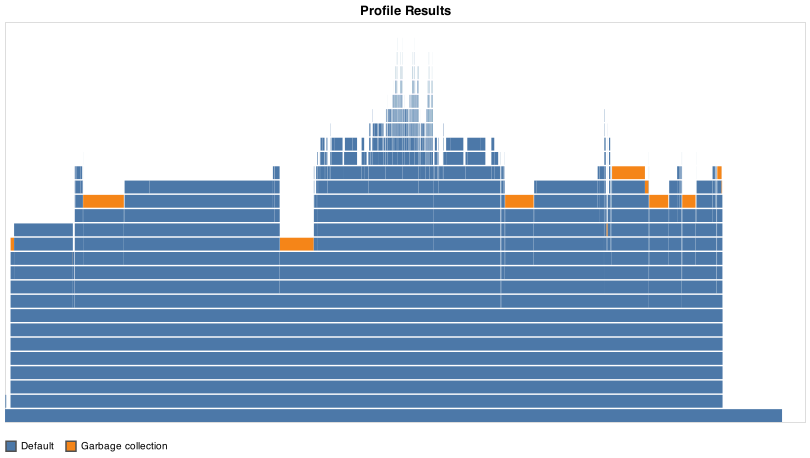

In [17]:
@profview rpf = RPForest(data, 20, 1)

#### Comparison to KDTree Constructor


In [14]:
m = 10_000_000
X = rand(10, m)
leafsize = 5
depth = floor(Int, log2(m/leafsize))

20

In [15]:
@benchmark rpf = RPForest($X, depth, 1)

BenchmarkTools.Trial: 
  memory estimate:  8.60 GiB
  allocs estimate:  9535782
  --------------
  minimum time:     22.904 s (24.53% GC)
  median time:      22.904 s (24.53% GC)
  mean time:        22.904 s (24.53% GC)
  maximum time:     22.904 s (24.53% GC)
  --------------
  samples:          1
  evals/sample:     1

#### Benchmark Column vs Row Array assignment

In [8]:
# Benchmark index storing speed
leaf_idxs = 2
ntrees = 100
nleafs = 128

# Row-wise
function rowwise_fill(A, row)
    m,n = size(A)
    for i in 1:m
        A[i, :] = row
    end
end

A = Array{Array{Int,1},2}(undef, ntrees, nleafs)
row = fill(rand(1:10, leaf_idxs), nleafs)
println("Row-wise: ")
@btime rowwise_fill(A, row)

function colwise_fill(A, col)
    m,n = size(A)
    for j in 1:n
        A[:, j] = col
    end
end

A = Array{Array{Int, 1}, 2}(undef, nleafs, ntrees)
col = fill(rand(1:10, leaf_idxs), nleafs)
println("Col-wise: ")
@btime colwise_fill(A, col)

A = Array{Array{Int, 1}, 2}(undef, nleafs, ntrees)
col = fill(rand(1:10, leaf_idxs), nleafs, 1)
println("Col-wise (true colum array): ")
@btime colwise_fill(A, col)

Row-wise: 
  21.055 μs (0 allocations: 0 bytes)
Col-wise: 
  17.786 μs (0 allocations: 0 bytes)
Col-wise (true colum array): 
  15.654 μs (0 allocations: 0 bytes)


In [9]:
# Different sized index vectors
col = fill(rand(1:10, leaf_idxs), nleafs, 1)
col[2:2:nleafs, :] = fill(rand(1:10, leaf_idxs + 2), nleafs÷2, 1)
println("Col-wise (true colum array): ")
@btime colwise_fill(A, col)

Col-wise (true colum array): 
  16.062 μs (0 allocations: 0 bytes)


In [10]:
nvecs = 10
ndims = 1000
R = randn(nvecs, ndims)
R ./= sum(R.^2, dims=2) .^ 0.5
println("Norms (Should be 1):")
println(sum(R.^2 , dims=2) .^ 0.5)
println("Orthogonality (Should be close to zero):")
println(R * R[1, :])

Norms (Should be 1):
[0.9999999999999993; 0.999999999999999; 0.9999999999999997; 1.0000000000000004; 0.9999999999999994; 1.0000000000000004; 0.9999999999999994; 0.9999999999999997; 1.0; 0.9999999999999997]
Orthogonality (Should be close to zero):
[0.9999999999999993, 0.01834033990650254, -0.038043755112036365, 0.019597866034807204, 0.014243418262783877, -0.026705068521216044, -0.02286981067305804, -0.031622310297669404, -0.010918502118004924, 0.020998734795485974]


### Column v Rows Benchmarking notes
1. Scales linearly with ntrees
2. Scales linearly with nleafs
3. Not affected by length of index vectors (Even when index vectors have different lengths

#### Alternate idea

But was slower

In [ ]:
function medianperm(x::Array{T, 1}) where T <: Real
    n::Int = length(x)
    sortidx::Array{Int, 1} = sortperm(x)
    mi::Int = isodd(n) ? n ÷ 2 + 1 : n ÷ 2
    med::T = isodd(n) ? x[mi] : (x[mi] + x[mi+1]) / 2 
    return med, mi, sortidx
end
    
""" 
    RPForest(data, maxdepth) -> ensemble

    Constructor for ensemble of sparse random projection trees with voting
    Notes:
        Node split values are stored in a 1D array and indexes are adjusted accordingly
"""
function RPForest(data::Array{T, 2}, maxdepth::Int, ntrees::Int) where T
    # Need depth check. If depth is too large raise exception
    ndims, npoints = size(data)
    sparse_vecs::Bool = ndims > 500
    random_vectors = random_projections(T, maxdepth*ntrees, ndims, sparse = sparse_vecs)
    nsplits = 2^maxdepth -1 # Number of splits in the tree (Same as number of non-leaf nodes)
    splits = zeros(T, ntrees, nsplits) # Array for storing hyperplane split values
    projections = random_vectors * data # projection[i, j] = the projection of point j onto the ith random vector
    nleafs = 2^maxdepth
    leaf_node_data_idxs = Array{Array{Int, 1}, 2}(undef, nleafs, ntrees) # Array for storing data indexes at the leaf
    
    for t in 1:ntrees
        prev_level = [collect(1:npoints)]
        next_level = Array{Array{Int, 1}, 2}(undef, 2, 1)
        next_split_idx = 1
        for d in 1:maxdepth
            proj_row = (t-1)*maxdepth + d # Current row of projection values
            for i in 1:length(prev_level)
                idxs = prev_level[i]
                # Compute median value of the projection of all current datapoints
                med::T, mi::Int64, sortperm = medianperm(projections[proj_row, idxs])
                splits[t, next_split_idx] = med
                next_split_idx += 1
                # Separate data points across hyperplane using the median
                next_level[2*i - 1] = idxs[sortperm[1:mi]]
                next_level[2*i] = idxs[sortperm[mi+1:end]]
                
            end
            prev_level = next_level
            next_level = Array{Array{Int, 1}, 2}(undef, 2^(d+1), 1)
        end
        leaf_node_data_idxs[:, t] = prev_level
    end
            
    return RPForest(data, npoints, ndims, maxdepth, ntrees, random_vectors, splits, leaf_node_data_idxs)
end

In [ ]:
rpf